In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

from sklearn.model_selection import train_test_split

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

import warnings
warnings.filterwarnings('ignore')

In [61]:
data = pd.read_csv('../data/almost_data.csv')
target = pd.read_csv('../data/Target.csv')

In [62]:
# data['Date et heure de comptage'] = pd.to_datetime([ data['Date et heure de comptage'][i].replace('+01:00', '') for i in range(data.shape[0])], utc=True)
data['Date et heure de comptage'] = pd.to_datetime(data['Date et heure de comptage'], utc=True)
# data['Date et heure de comptage'].apply(lambda x: pd.to_datetime(x).tz_convert('US/Eastern'))
data['Date et heure de comptage'] = data['Date et heure de comptage'].dt.tz_localize(None)

data

,Unnamed: 0,Date et heure de comptage,Vacance,Variation de pression en 3 heures,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Humidité,Visibilité horizontale,Meteo pres,...,Libelle_AV_Champs_Elysees,Libelle_Convention,Libelle_Sts_Peres,Etat trafic_Bloqué,Etat trafic_Fluide,Etat trafic_Inconnu,Etat trafic_Pré-saturé,Etat trafic_Saturé,Etat arc_Barré,Etat arc_Invalide
0,0,2021-12-01 03:00:00,0,-420,230,7,281,90,15000,0,...,1,0,0,0,0,0,1,0,0,1
1,1,2021-12-01 03:00:00,0,-420,230,7,281,90,15000,0,...,0,0,1,0,1,0,0,0,0,1
2,2,2021-12-01 03:00:00,0,-420,230,7,281,90,15000,0,...,0,1,0,0,1,0,0,0,0,1
3,3,2021-12-01 04:00:00,0,-420,230,7,281,90,15000,0,...,1,0,0,0,1,0,0,0,0,1
4,4,2021-12-01 04:00:00,0,-420,230,7,281,90,15000,0,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,29223,2023-01-27 19:00:00,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
29224,29224,2023-01-27 20:00:00,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
29225,29225,2023-01-27 21:00:00,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
29226,29226,2023-01-27 22:00:00,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1


In [42]:
type(data['Date et heure de comptage'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [43]:
data.drop('Unnamed: 0', axis=1, inplace=True )
target.drop(['Unnamed: 0', 'index'], axis=1, inplace=True )

In [23]:
target

,Débit horaire,Taux d'occupation
0,589.0,17.67389
1,63.0,0.84667
2,63.0,0.41278
3,482.0,7.00278
4,49.0,0.75111
...,...,...
29223,NaN,6.62778
29224,NaN,5.27722
29225,NaN,3.63278
29226,NaN,2.63889


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype              
---  ------                             --------------  -----              
 0   Date et heure de comptage          29228 non-null  datetime64[ns, UTC]
 1   Vacance                            29228 non-null  int64              
 2   Variation de pression en 3 heures  29228 non-null  int64              
 3   Direction du vent moyen 10 mn      29228 non-null  int64              
 4   Vitesse du vent moyen 10 mn        29228 non-null  int64              
 5   Température                        29228 non-null  int64              
 6   Humidité                           29228 non-null  int64              
 7   Visibilité horizontale             29228 non-null  int64              
 8   Meteo pres                         29228 non-null  int64              
 9   Meteo pass                         29228 non-null 

In [27]:
data_train, data_test = train_test_split(pd.concat([data, target], axis=1).set_index('Date et heure de comptage'), test_size=.2, shuffle=False)


In [35]:
def time_series_graph(data_train, data_test, target='Taux d\'occupation', street='Libelle_AV_Champs_Elysees'):
    fig, ax = plt.subplots(figsize=(11, 6))
    data_train[data_train[street] == 1][target].plot(ax=ax, label='train')
    data_test[data_test[street] == 1][target].plot(ax=ax, label='test')
    ax.set_title(target)
    ax.legend()
    plt.show()

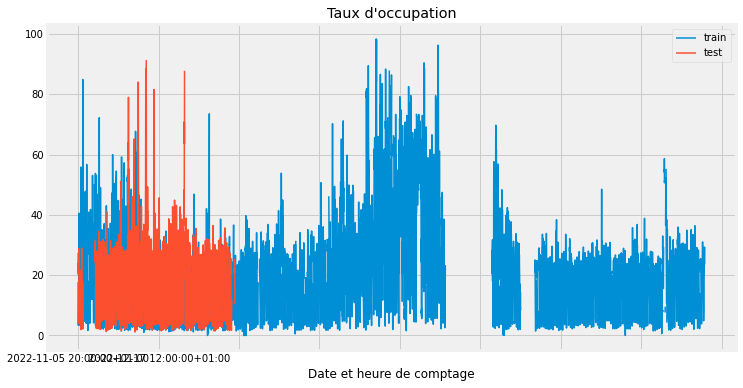

In [36]:
time_series_graph(data_train, data_test)

## Prophet 

In [52]:
indexes = data[data['Libelle_AV_Champs_Elysees'] == 1].index

df_prophet_1 = pd.concat([data[data['Libelle_AV_Champs_Elysees'] == 1]['Date et heure de comptage'], target['Débit horaire'].iloc[indexes]], axis=1)
df_prophet_2 = pd.concat([data['Date et heure de comptage'], target['Taux d\'occupation']], axis=1)

df_prophet_1.rename(columns={'Date et heure de comptage': 'ds', 'Débit horaire': 'y'}, inplace=True)
df_prophet_2.rename(columns={'Date et heure de comptage': 'ds', 'Taux d\'occupation' : 'y'}, inplace=True)



df_prophet_1

,ds,y
0,2021-12-01 03:00:00,589.0
3,2021-12-01 04:00:00,482.0
6,2021-12-01 05:00:00,381.0
9,2021-12-01 06:00:00,665.0
13,2021-12-01 07:00:00,1028.0
...,...,...
29191,2023-01-26 19:00:00,1116.0
29193,2023-01-26 20:00:00,1071.0
29197,2023-01-26 21:00:00,937.0
29200,2023-01-26 22:00:00,781.0


In [53]:
children_holidays = pd.read_csv('../data/vacances_scolaires.csv')
french_holidays = pd.read_csv('../data/jours_feries_metropole.csv')
start_date = pd.to_datetime('2021-12-01')
finish_date = pd.to_datetime('2023-02-01')

In [54]:
children_holidays['date'] = pd.to_datetime(children_holidays['date'], errors='coerce')
children_holidays = children_holidays[children_holidays['date'] >= start_date]
children_holidays = children_holidays[children_holidays['date'] <= finish_date]
children_holidays = children_holidays['date']
children_holidays = pd.DataFrame({
                                 'ds': children_holidays, 'holiday' : 'vacance'})
children_holidays

,ds,holiday
11657,2021-12-01,vacance
11658,2021-12-02,vacance
11659,2021-12-03,vacance
11660,2021-12-04,vacance
11661,2021-12-05,vacance
...,...,...
12080,2023-01-28,vacance
12081,2023-01-29,vacance
12082,2023-01-30,vacance
12083,2023-01-31,vacance


In [55]:
french_holidays['date'] = pd.to_datetime(french_holidays['date'], errors='coerce')
french_holidays = french_holidays[french_holidays['date'] >= start_date]
french_holidays = french_holidays[french_holidays['date'] <= finish_date]
french_holidays = french_holidays['date']
french_holidays = pd.DataFrame({ 
                                 'ds': french_holidays, 'holiday' : 'no_work'})
french_holidays

,ds,holiday
208,2021-12-25,no_work
209,2022-01-01,no_work
210,2022-04-18,no_work
211,2022-05-01,no_work
212,2022-05-08,no_work
213,2022-05-26,no_work
214,2022-06-06,no_work
215,2022-07-14,no_work
216,2022-08-15,no_work
217,2022-11-01,no_work


In [56]:
holidays = pd.concat([french_holidays, children_holidays])
holidays

,ds,holiday
208,2021-12-25,no_work
209,2022-01-01,no_work
210,2022-04-18,no_work
211,2022-05-01,no_work
212,2022-05-08,no_work
...,...,...
12080,2023-01-28,vacance
12081,2023-01-29,vacance
12082,2023-01-30,vacance
12083,2023-01-31,vacance


In [57]:
model_prophet_1 = Prophet()
model_prophet_2 = Prophet(holidays=holidays)

In [58]:
model_prophet_1.fit(df_prophet_1)

19:28:19 - cmdstanpy - INFO - Chain [1] start processing
19:28:21 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
model_prophet_1

TypeError: predict_seasonal_components() missing 1 required positional argument: 'df'